In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm

class Cat:
    def __init__(self, params:dict):
        self.params=params
        self.glued_result = np.zeros((100, 100))
        self.matrices={}
        self.v_matrices={}
        self.results_={} # 3d array
        self.v_results_={} # 3d array
        self.all_results={} # 3d array
        self.get_matrices()
        self.get_glued_result()
        self.get_v_matrices()
        

    def get_matrices(self):
        for key in params["ind_lim"].keys():
            row_min=min([tup[0] for tup in params["ind_lim"][key][:-1]])
            row_max=max([tup[0] for tup in params["ind_lim"][key][:-1]])
            col_min=min([tup[1] for tup in params["ind_lim"][key][:-1]])
            col_max=max([tup[1] for tup in params["ind_lim"][key][:-1]])
            if key not in self.matrices.keys():
                self.matrices[key]=self.params["ind_lim"][key][4](
                    self.params["domain"]["grid"][row_min:row_max, col_min:col_max]
                )
            else:
                self.matrices[key]=self.glued_result[row_min:row_max, col_min:col_max]
        return self
    
    def get_v_matrices(self):
        for key in params["ind_lim"].keys():
            row_min=min([tup[0] for tup in params["ind_lim"][key][:-1]])
            row_max=max([tup[0] for tup in params["ind_lim"][key][:-1]])
            col_min=min([tup[1] for tup in params["ind_lim"][key][:-1]])
            col_max=max([tup[1] for tup in params["ind_lim"][key][:-1]])
            if key not in self.v_matrices.keys():
                self.v_matrices[key]=self.params["ind_lim"][key][4](
                    self.params["domain"]["grid"][row_min:row_max, col_min:col_max]
                )
            else:
                self.v_matrices[key]=self.glued_result[row_min:row_max, col_min:col_max]
        return self         
        
    def get_glued_result(self):
        for key in params["ind_lim"].keys():
            row_min=min([tup[0] for tup in params["ind_lim"][key][:-1]])
            row_max=max([tup[0] for tup in params["ind_lim"][key][:-1]])
            col_min=min([tup[1] for tup in params["ind_lim"][key][:-1]])
            col_max=max([tup[1] for tup in params["ind_lim"][key][:-1]])
            self.glued_result[row_min:row_max, col_min:col_max] = self.matrices[key]
        return self
    
    def evolve_n_steps(self, steps):
        ht,hx,hy,Du,Dv=list(self.params["par"].values())[0:5]

        self.all_results=np.zeros((steps, 100, 100))
        self.all_results[0,:,:]=self.glued_result
        for key in self.matrices:

            row_min=min([tup[0] for tup in params["ind_lim"][key][:-1]])
            row_max=max([tup[0] for tup in params["ind_lim"][key][:-1]])
            col_min=min([tup[1] for tup in params["ind_lim"][key][:-1]])
            col_max=max([tup[1] for tup in params["ind_lim"][key][:-1]])

            self.results_[key]=np.zeros((steps, self.matrices[key].shape[0], self.matrices[key].shape[1]))
            self.results_[key][0,:,:]=self.matrices[key]
            results=self.results_[key]
            self.v_results_[key]=np.zeros((steps, self.matrices[key].shape[0], self.matrices[key].shape[1]))
            self.v_results_[key][0,:,:]=self.v_matrices[key]
            v_results=self.v_results_[key]
            for i in range(steps-1): 

                if key not in ["head","body","tail","LFL", "LBL", "RFL", "RBL"]:
                    continue
                else:
                    # matrix u
                    self.results_[key][i+1,1:-1:,1:-1]=results[i,1:-1,1:-1]+Du*ht/(hx**2)*(results[i,2:,1:-1]+results[i,:-2,1:-1]-2*results[i,1:-1,1:-1])+Du*ht/(hy**2)*(results[i,1:-1,2:]+results[i,1:-1,:-2]-2*results[i,1:-1,1:-1])+self.params["func"]["f"](
                        results[i,1:-1,1:-1],v_results[i,1:-1,1:-1],self.params["par"]
                    )
                    self.results_[key][i+1,0,:]=self.results_[key][i,1,:]
                    self.results_[key][i+1,-1,:]=self.results_[key][i,-2,:]
                    self.results_[key][i+1,:,0]=self.results_[key][i,:,1]
                    self.results_[key][i+1,:,-1]=self.results_[key][i,:,-2]
                    
                    
                    # matrix v
                    self.v_results_[key][i+1,1:-1,1:-1]=v_results[i,1:-1,1:-1]+Dv*ht/(hx**2)*(v_results[i,2:,1:-1]+v_results[i,:-2,1:-1]-2*v_results[i,1:-1,1:-1])+Du*ht/(hy**2)*(v_results[i,1:-1,2:]+v_results[i,1:-1,:-2]-2*v_results[i,1:-1,1:-1])+self.params["func"]["g"](
                        results[i,1:-1,1:-1],v_results[i,1:-1,1:-1],self.params["par"]
                    )
                    self.v_results_[key][i+1,0,:]=self.v_results_[key][i,1,:]
                    self.v_results_[key][i+1,-1,:]=self.v_results_[key][i,-2,:]
                    self.v_results_[key][i+1,:,0]=self.v_results_[key][i,:,1]
                    self.v_results_[key][i+1,:,-1]=self.v_results_[key][i,:,-2]

                    self.all_results[i+1,row_min:row_max, col_min:col_max]=self.results_[key][i+1,:,:]
                    results=self.results_[key]
                    v_results=self.v_results_[key]
                
                
        return self


params={"ind_lim":{
    "head": [(0,40), (0,60), (20,40), (20,60), lambda x: np.random.random(x.shape)],
    "body": [(20,30), (20,70), (70,30), (70,70), lambda x: np.random.random(x.shape)],
    "tail": [(70,45), (70,55), (100, 45), (100,55), lambda x: np.random.random(x.shape)],
    "LFL": [(20,0), (20,30), (30,0), (30,30), lambda x: np.random.random(x.shape)],
    "LBL": [(60,0), (60,30), (70,0), (70,30), lambda x: np.random.random(x.shape)],
    "RFL": [(20,70), (20,100), (30,70), (30,100), lambda x: np.random.random(x.shape)],
    "RBL": [(60,70), (60,100), (70, 70), (70,100), lambda x: np.random.random(x.shape)],
    "I": [(0,0), (0,40), (20,0), (20, 40), lambda x: np.zeros(x.shape)],
    "II": [(0,60), (0,100), (20,60), (20,100), lambda x: np.zeros(x.shape)],
    "III": [(30,0), (30,30), (60,0), (60,30), lambda x: np.zeros(x.shape)],
    "IV": [(30,70), (30,100), (60,70), (60,100), lambda x: np.zeros(x.shape)],
    "V": [(70,0), (70,45), (100,0), (100,45), lambda x: np.zeros(x.shape)],
    "VI": [(70,55), (70,100), (100,55), (100,100), lambda x: np.zeros(x.shape)]
    },
        "domain":{
            "grid":np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))[0],
            "dx":1
    },
    "func":{
        "f": lambda u, v, dict_par: dict_par['a']+dict_par['b']*(u**2)/(v*(1+dict_par['K']*u**2))-dict_par['c']*u,
        "g": lambda u, v, dict_par: dict_par['d']*u**2-dict_par['e']*v
    },
    "par":{
        "ht":0.1,
        "hx":1,
        "hy":1,
        "Du":0.1,
        "Dv":2.0,
        "a":0,
        "b":0.5,
        "c":0.5,
        "d":0.5,
        "e":0.45,
        "K":0.238

    }        
}

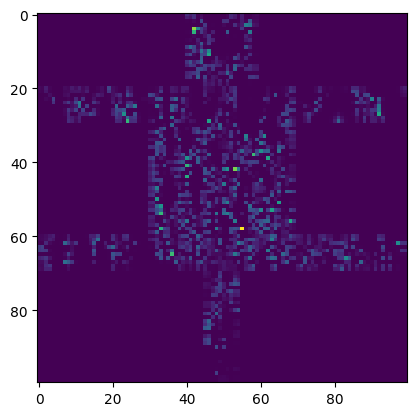

0.2336698347555378


'\nfig=plt.figure()\nfigs=x.all_results[0,:,:]\ndef animation(j):\n    figs=x.all_results[j,:,:]\n    return figs\n\nanim=anm.FuncAnimation(fig,\n                      func=animation,\n                      interval = 10,\n                      blit=True)\nplt.show()\n'

In [39]:
x = Cat(params)
plt.imshow(x.glued_result)
#plt.show()
#print(x.matrices["head"])
x.evolve_n_steps(15)
plt.imshow(x.all_results[-1,:,:])
plt.show()
print(np.var(x.all_results[-1,:,:]))



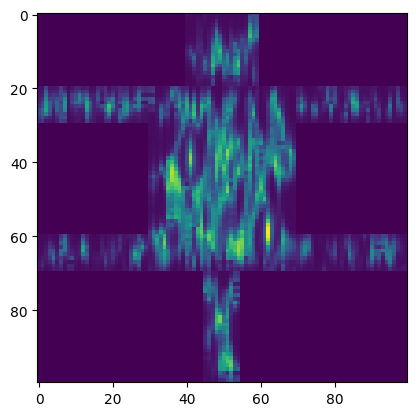

0.8385528191128242


In [96]:
params={"ind_lim":{
    "head": [(0,40), (0,60), (20,40), (20,60), lambda x: np.random.random(x.shape)],
    "body": [(20,30), (20,70), (70,30), (70,70), lambda x: np.random.random(x.shape)],
    "tail": [(70,45), (70,55), (100, 45), (100,55), lambda x: np.random.random(x.shape)],
    "LFL": [(20,0), (20,30), (30,0), (30,30), lambda x: np.random.random(x.shape)],
    "LBL": [(60,0), (60,30), (70,0), (70,30), lambda x: np.random.random(x.shape)],
    "RFL": [(20,70), (20,100), (30,70), (30,100), lambda x: np.random.random(x.shape)],
    "RBL": [(60,70), (60,100), (70, 70), (70,100), lambda x: np.random.random(x.shape)],
    "I": [(0,0), (0,40), (20,0), (20, 40), lambda x: np.zeros(x.shape)],
    "II": [(0,60), (0,100), (20,60), (20,100), lambda x: np.zeros(x.shape)],
    "III": [(30,0), (30,30), (60,0), (60,30), lambda x: np.zeros(x.shape)],
    "IV": [(30,70), (30,100), (60,70), (60,100), lambda x: np.zeros(x.shape)],
    "V": [(70,0), (70,45), (100,0), (100,45), lambda x: np.zeros(x.shape)],
    "VI": [(70,55), (70,100), (100,55), (100,100), lambda x: np.zeros(x.shape)]
    },
        "domain":{
            "grid":np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))[0],
            "dx":1
    },
    "func":{
        "f": lambda u, v, dict_par: dict_par['a']+dict_par['b']*(u**2)/(v*(1+dict_par['K']*u**2))-dict_par['c']*u,
        "g": lambda u, v, dict_par: dict_par['d']*u**2-dict_par['e']*v
    },
    "par":{
        "ht":0.1,
        "hx":1,
        "hy":1,
        "Du":0.1,
        "Dv":2.0,
        "a":0.05,
        "b":0.5,
        "c":0.5,
        "d":0.5,
        "e":0.45,
        "K":0.15

    }        
}

x = Cat(params)
x.evolve_n_steps(30)
plt.imshow(x.all_results[-1,:,:])
plt.show()
print(np.var(x.all_results[-1,:,:]))

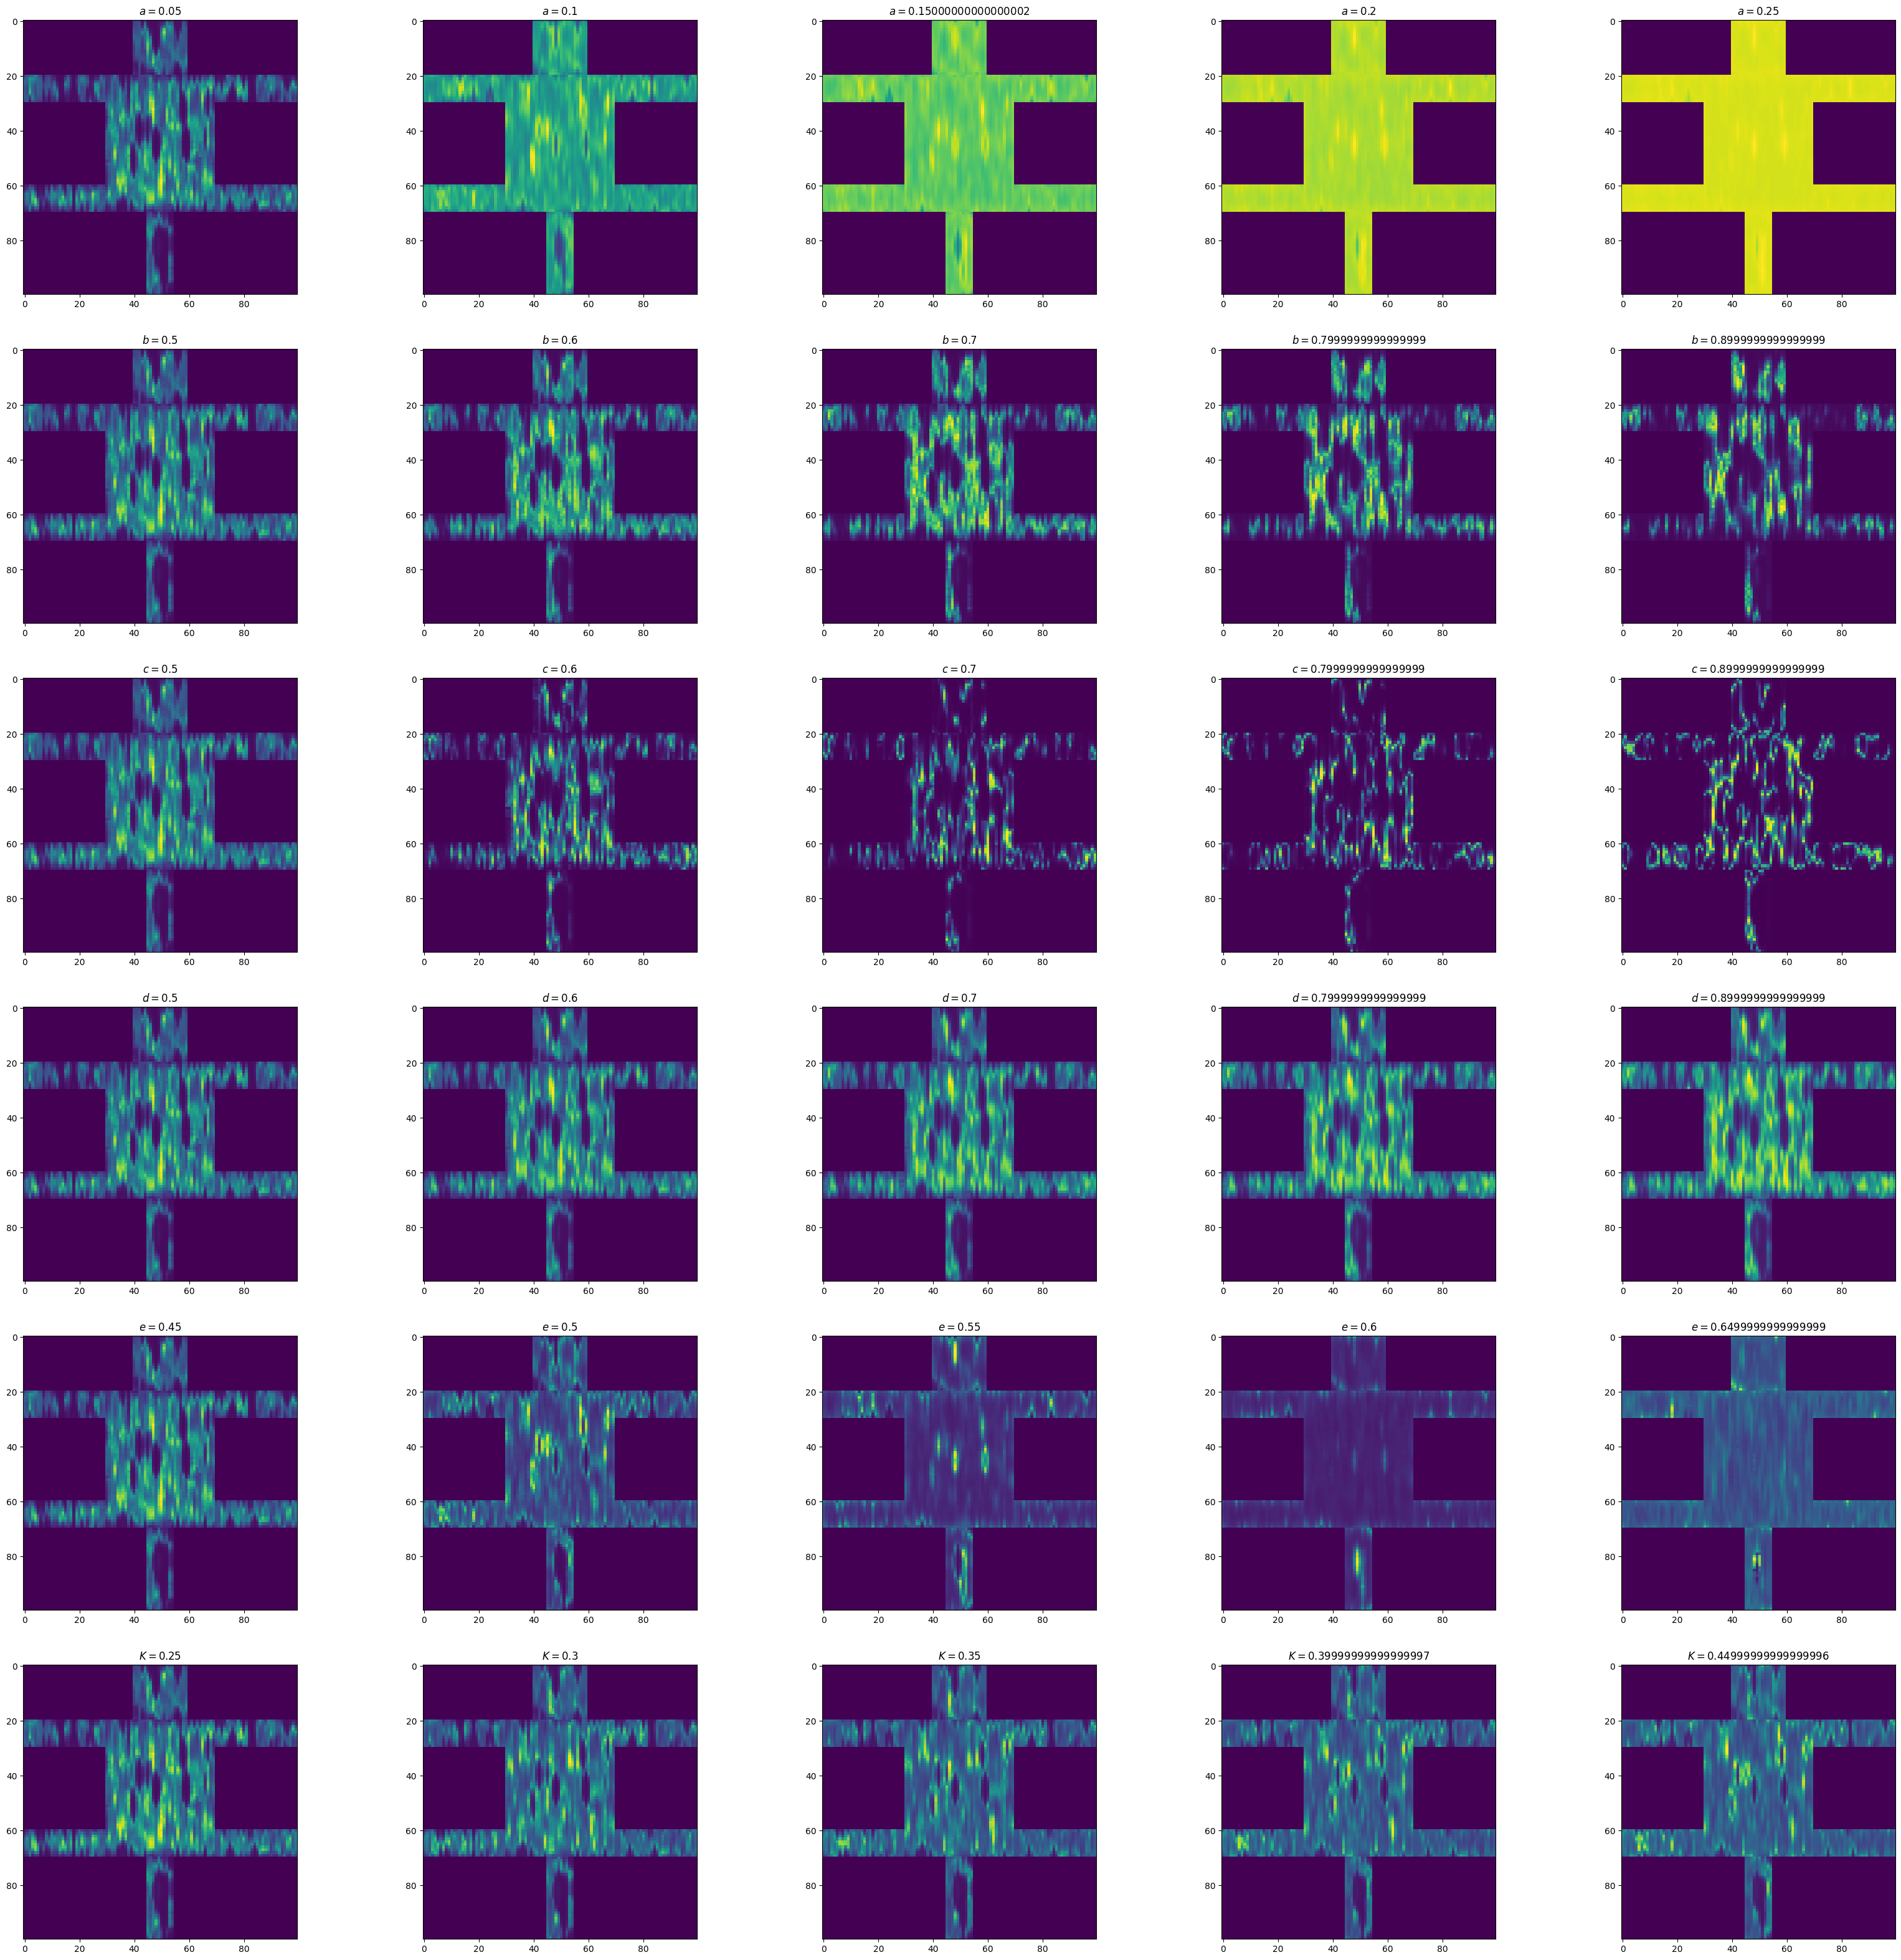

In [115]:


class Cat:
    def __init__(self, params:dict):
        self.params=params
        self.glued_result = np.zeros((100, 100))
        self.matrices={}
        self.v_matrices={}
        self.results_={} # 3d array
        self.v_results_={} # 3d array
        self.all_results={} # 3d array
        self.variance=np.zeros((6,5))
        self.get_matrices()
        self.get_glued_result()
        self.get_v_matrices()
        

    def get_matrices(self):
        for key in params["ind_lim"].keys():
            row_min=min([tup[0] for tup in params["ind_lim"][key][:-1]])
            row_max=max([tup[0] for tup in params["ind_lim"][key][:-1]])
            col_min=min([tup[1] for tup in params["ind_lim"][key][:-1]])
            col_max=max([tup[1] for tup in params["ind_lim"][key][:-1]])
            if key not in self.matrices.keys():
                self.matrices[key]=self.params["ind_lim"][key][4](
                    self.params["domain"]["grid"][row_min:row_max, col_min:col_max]
                )
            else:
                self.matrices[key]=self.glued_result[row_min:row_max, col_min:col_max]
        return self
    
    def get_v_matrices(self):
        for key in params["ind_lim"].keys():
            row_min=min([tup[0] for tup in params["ind_lim"][key][:-1]])
            row_max=max([tup[0] for tup in params["ind_lim"][key][:-1]])
            col_min=min([tup[1] for tup in params["ind_lim"][key][:-1]])
            col_max=max([tup[1] for tup in params["ind_lim"][key][:-1]])
            if key not in self.v_matrices.keys():
                self.v_matrices[key]=self.params["ind_lim"][key][4](
                    self.params["domain"]["grid"][row_min:row_max, col_min:col_max]
                )
            else:
                self.v_matrices[key]=self.glued_result[row_min:row_max, col_min:col_max]
        return self         
        
    def get_glued_result(self):
        for key in params["ind_lim"].keys():
            row_min=min([tup[0] for tup in params["ind_lim"][key][:-1]])
            row_max=max([tup[0] for tup in params["ind_lim"][key][:-1]])
            col_min=min([tup[1] for tup in params["ind_lim"][key][:-1]])
            col_max=max([tup[1] for tup in params["ind_lim"][key][:-1]])
            self.glued_result[row_min:row_max, col_min:col_max] = self.matrices[key]
        return self
    
    def evolve_n_steps(self, steps, fun):
        ht,hx,hy,Du,Dv=list(self.params["par"].values())[0:5]

        self.all_results=np.zeros((steps, 100, 100))
        self.all_results[0,:,:]=self.glued_result
        for key in self.matrices:

            row_min=min([tup[0] for tup in params["ind_lim"][key][:-1]])
            row_max=max([tup[0] for tup in params["ind_lim"][key][:-1]])
            col_min=min([tup[1] for tup in params["ind_lim"][key][:-1]])
            col_max=max([tup[1] for tup in params["ind_lim"][key][:-1]])

            self.results_[key]=np.zeros((steps, self.matrices[key].shape[0], self.matrices[key].shape[1]))
            self.results_[key][0,:,:]=self.matrices[key]
            results=self.results_[key]
            self.v_results_[key]=np.zeros((steps, self.matrices[key].shape[0], self.matrices[key].shape[1]))
            self.v_results_[key][0,:,:]=self.v_matrices[key]
            v_results=self.v_results_[key]
            for i in range(steps-1): 

                if key not in ["head","body","tail","LFL", "LBL", "RFL", "RBL"]:
                    continue
                else:
                    # matrix u
                    self.results_[key][i+1,1:-1:,1:-1]=results[i,1:-1,1:-1]+Du*ht/(hx**2)*(results[i,2:,1:-1]+results[i,:-2,1:-1]-2*results[i,1:-1,1:-1])+Du*ht/(hy**2)*(results[i,1:-1,2:]+results[i,1:-1,:-2]-2*results[i,1:-1,1:-1])+fun["u"](
                        results[i,1:-1,1:-1],v_results[i,1:-1,1:-1]
                    )
                    self.results_[key][i+1,0,:]=self.results_[key][i,1,:]
                    self.results_[key][i+1,-1,:]=self.results_[key][i,-2,:]
                    self.results_[key][i+1,:,0]=self.results_[key][i,:,1]
                    self.results_[key][i+1,:,-1]=self.results_[key][i,:,-2]
                    
                    
                    # matrix v
                    self.v_results_[key][i+1,1:-1,1:-1]=v_results[i,1:-1,1:-1]+Dv*ht/(hx**2)*(v_results[i,2:,1:-1]+v_results[i,:-2,1:-1]-2*v_results[i,1:-1,1:-1])+Du*ht/(hy**2)*(v_results[i,1:-1,2:]+v_results[i,1:-1,:-2]-2*v_results[i,1:-1,1:-1])+fun["v"](
                        results[i,1:-1,1:-1],v_results[i,1:-1,1:-1]
                    )
                    self.v_results_[key][i+1,0,:]=self.v_results_[key][i,1,:]
                    self.v_results_[key][i+1,-1,:]=self.v_results_[key][i,-2,:]
                    self.v_results_[key][i+1,:,0]=self.v_results_[key][i,:,1]
                    self.v_results_[key][i+1,:,-1]=self.v_results_[key][i,:,-2]

                    self.all_results[i+1,row_min:row_max, col_min:col_max]=self.results_[key][i+1,:,:]
                    results=self.results_[key]
                    v_results=self.v_results_[key]
                
                
        return self
    

    def make_pattern_comparison(self, axs, params):
      assert isinstance(params, dict), "You must give a dict object in the input"
      cnt_r = 0
      for key in params['pars'].keys():
        a,b,c,d,e,K = 0.05, 0.5, 0.5, 0.5, 0.45, 0.238 # default params
        default_params = {"a": a, "b": b, "c": c, "d": d, "e": e, "K": K}
        assert default_params.keys() == params["pars"].keys()
        cnt_c = 0
        for p in params["pars"][key]:
          default_params[key] = p
          f={
              "u": lambda u, v: default_params['a']+default_params['b']*(u**2)/(v*(1+default_params['K']*u**2))-default_params['c']*u,
              "v": lambda u, v: default_params['d']*u**2-default_params['e']*v
          }
          x.evolve_n_steps(30,f)
          u = x.all_results[-1,:,:]
          self.variance[cnt_r, cnt_c]=np.var(u)

          axs[cnt_r, cnt_c].imshow(u)
          axs[cnt_r, cnt_c].set_title(f"${key} = {default_params[key]}$")

          cnt_c += 1
        cnt_r += 1
      return axs, self.variance

params={"ind_lim":{
    "head": [(0,40), (0,60), (20,40), (20,60), lambda x: np.random.random(x.shape)],
    "body": [(20,30), (20,70), (70,30), (70,70), lambda x: np.random.random(x.shape)],
    "tail": [(70,45), (70,55), (100, 45), (100,55), lambda x: np.random.random(x.shape)],
    "LFL": [(20,0), (20,30), (30,0), (30,30), lambda x: np.random.random(x.shape)],
    "LBL": [(60,0), (60,30), (70,0), (70,30), lambda x: np.random.random(x.shape)],
    "RFL": [(20,70), (20,100), (30,70), (30,100), lambda x: np.random.random(x.shape)],
    "RBL": [(60,70), (60,100), (70, 70), (70,100), lambda x: np.random.random(x.shape)],
    "I": [(0,0), (0,40), (20,0), (20, 40), lambda x: np.zeros(x.shape)],
    "II": [(0,60), (0,100), (20,60), (20,100), lambda x: np.zeros(x.shape)],
    "III": [(30,0), (30,30), (60,0), (60,30), lambda x: np.zeros(x.shape)],
    "IV": [(30,70), (30,100), (60,70), (60,100), lambda x: np.zeros(x.shape)],
    "V": [(70,0), (70,45), (100,0), (100,45), lambda x: np.zeros(x.shape)],
    "VI": [(70,55), (70,100), (100,55), (100,100), lambda x: np.zeros(x.shape)]
    },
        "domain":{
            "grid":np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))[0],
            "dx":1
    },
    "func":{
        "f": lambda u, v, dict_par: dict_par['a']+dict_par['b']*(u**2)/(v*(1+dict_par['K']*u**2))-dict_par['c']*u,
        "g": lambda u, v, dict_par: dict_par['d']*u**2-dict_par['e']*v
    },
    "par":{
        "ht":0.1,
        "hx":1,
        "hy":1,
        "Du":0.1,
        "Dv":2.0
    },
    "pars":{
        "a": np.arange(0.05, 0.3, 0.05),
        "b": np.arange(0.5, 1.0, 0.1),
        "c": np.arange(0.5, 1.0, 0.1),
        "d": np.arange(0.5, 1.0, 0.1),
        "e": np.arange(0.45, 0.7, 0.05),
        "K": np.arange(0.25, 0.5, 0.05)
    }
        
}

fig, axs = plt.subplots(6, 5, figsize = (40, 40))

x=Cat(params)
axs,variance = x.make_pattern_comparison(axs, params)
plt.show()

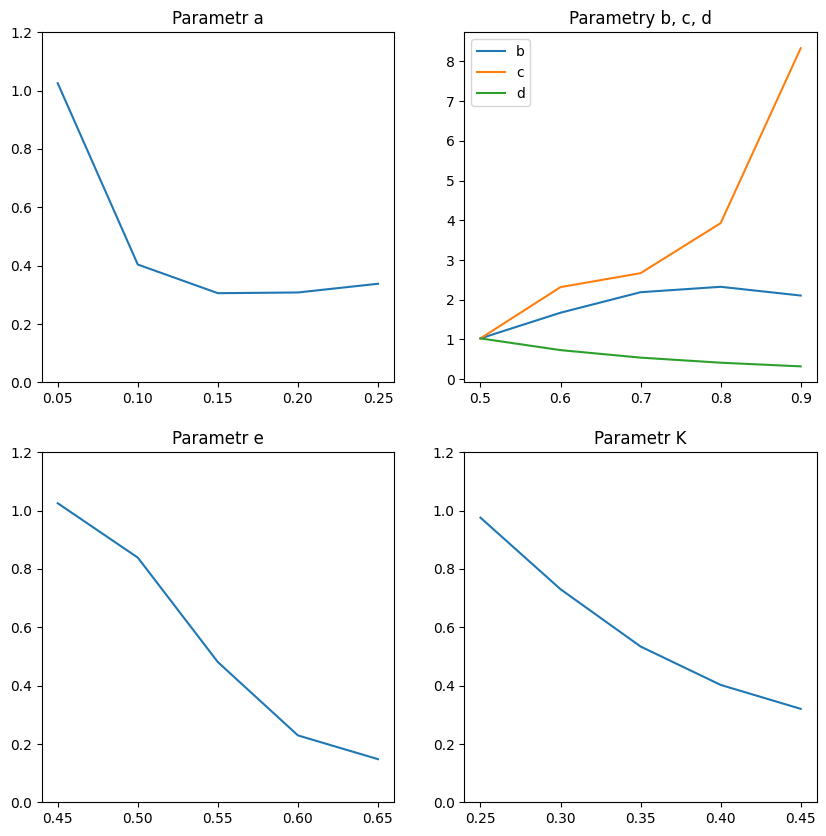

In [130]:
fig,axs=plt.subplots(2, 2, figsize=(10,10))
a=np.arange(0.05,0.3,0.05)
b=np.arange(0.5,1,0.1)
e=np.arange(0.45,0.7,0.05)
K=np.arange(0.25,0.5,0.05)
axs[0,0].plot(a,variance[0,:])
axs[0,0].set_title("Parametr a")
axs[0,0].set_ylim((0,1.2))
axs[0,1].plot(b,variance[1,:], label="b")
axs[0,1].plot(b,variance[2,:], label="c")
axs[0,1].plot(b,variance[3,:], label="d")
axs[0,1].legend()
axs[0,1].set_title("Parametry b, c, d")
axs[1,0].plot(e,variance[-2,:])
axs[1,0].set_title("Parametr e")
axs[1,0].set_ylim((0,1.2))
axs[1,1].plot(K,variance[-1,:])
axs[1,1].set_title("Parametr K")
axs[1,1].set_ylim((0,1.2))
plt.show()